In [1]:
import sys, os
from tqdm import tqdm
import numpy as np
from scipy import integrate, interpolate, special

from astropy import units, constants
from astropy.cosmology import Planck18 as cosmo
from hmf import Transfer, MassFunction

import matplotlib.pyplot as plt

# Basic Parameter Definitions

Some of these are my choice. Some of these are hardcoded by `21cmFAST`.

In [2]:
# M_Sun / Mpc^3
rhoCrit0 = cosmo.critical_density(0).to(units.M_sun / units.Mpc**3).value

# 21cmFAST Definitions for Critical Collapse
SHETH_a = 0.73
SHETH_A = 0.353
SHETH_p = 0.175
Deltac = 1.68

# Default Duty Cycle Parametrization
M_TURN = 5.012e+08
M_MIN = M_TURN/50

# Convenience Methods

In [3]:
# I took these definitions from 21cmFAST. 
def MtoR(M):
    return np.cbrt(3*M/(4*np.pi*cosmo.Om0*rhoCrit0))

def RtoM(R):
    return 4*np.pi*cosmo.Om0*rhoCrit0*R**3 / 3


# This is the fitting function for the Dicke Linear Growth Factor. I took this from 21cmFAST
def dicke(z):
    omegaM_z = cosmo.Om(z)
    
    dicke_z = 2.5 * omegaM_z / (1.0 / 70.0 + omegaM_z * (209 - omegaM_z) / 140.0 + pow(omegaM_z, 4.0/7.0))
    dicke_0 = 2.5 *  cosmo.Om0 / (1.0 / 70.0 +  cosmo.Om0 * (209 -  cosmo.Om0) / 140.0 + pow( cosmo.Om0, 4.0/7.0))
    
    return dicke_z / (dicke_0 * (1.0 + z))


# This is the top-hat window function. I took this from 21cmFAST
def W(k, R):
    
    kR = k * R
    mask = kR >= 1e-4
    
    w = np.where(mask, 3.0 * (np.sin(kR) / kR**3 - np.cos(kR) / kR**2), 0.0)
    return w

# This is the derivative of the top-hat window function with respect to R. I took this from 21cmFAST
def dWdR(k, R):
    kR = k * R
    mask = k >= 1e-10

    dwdr = np.where(mask, (9 * np.cos(kR) * k / kR**3) + (3 * np.sin(kR) * (1 - 3 / (kR * kR)) / (kR * R)), 0.0)
    return dwdr

# Generating Interpolated Power Spectrum from EH

In [4]:
tr = Transfer(cosmo_model = cosmo, transfer_model = 'EH', z = 0)

interp_k = tr.k * cosmo.h # to units without `h`
interp_T = tr.transfer_function / np.amax(tr.transfer_function) # normalized
interp_P = interp_k**2 * interp_T**2 * interp_k**cosmo.to_format('mapping')['meta']['n']

# Defining an interpolated Power Spectrum that must be normalized to match Sigma8
PowerSpectrum = interpolate.CubicSpline(interp_k, interp_P)

# Doing the Sigma8 Normalization
Radius_8 = 8.0/cosmo.h 
integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) * W(np.exp(logk), Radius_8)**2
result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
sigma_norm = cosmo.to_format('mapping')['meta']['sigma8']/np.sqrt(result[0])

# Redefining the Power Spectrum to be consistent with Sigma8
PowerSpectrum = interpolate.CubicSpline(interp_k, sigma_norm**2*interp_P)

# Operations on the Power Spectrum

In [5]:
def sigma_z0(M):
    Radius = MtoR(M)
    
    integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) * W(np.exp(logk), Radius)**2
    result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
    
    return np.sqrt(result[0])

def dsigmasqdm_z0(M):
    Radius = MtoR(M)
        
    # Calculating drdrm
    drdm = 1.0 / (4.0*np.pi * cosmo.Om(0)*rhoCrit0 * Radius*Radius)
    
    # Defining the integrand
    integrand = lambda logk: np.exp(logk)* PowerSpectrum(np.exp(logk)) *\
                             2* W(np.exp(logk), Radius) * dWdR(np.exp(logk), Radius) * drdm
    
    result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
    return result[0]

############################################################################
###   The above is slow so we will define some interpolating functions   ###
############################################################################

interp_m = np.geomspace(M_MIN, RtoM(512), 4001)
interp_sigma = np.zeros_like(interp_m)
interp_dsigma_dm = np.zeros_like(interp_m)

for i in tqdm(range(len(interp_m))):
    interp_sigma[i] = sigma_z0(interp_m[i])
    interp_dsigma_dm[i] = dsigmasqdm_z0(interp_m[i])
    
sigma_z0 = interpolate.CubicSpline(interp_m, interp_sigma)
dsigmasqdm_z0 = interpolate.CubicSpline(interp_m, interp_dsigma_dm)

  0%|          | 0/4001 [00:00<?, ?it/s]

 33%|███▎      | 1331/4001 [00:55<02:10, 20.47it/s]/tmp/ipykernel_2240042/572478220.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(integrand, np.log(interp_k[0]), np.log(interp_k[-1]), epsabs = 0, epsrel = 1e-6)
 93%|█████████▎| 3716/4001 [03:08<00:18, 15.41it/s]/tmp/ipykernel_2240042/572478220.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can 

In [6]:
np.save('./ResStack.npy', np.vstack((interp_m, interp_sigma, interp_dsigma_dm)))

# Press Schechter and Sheth Tormen Mass Functions

In [7]:
# This is the Sheth-Tormen Mass Function. This is exactly taken from 21cmFAST, which is why the conventions
# are a little bit weird. Anyways, this matches HMF precisely if the Sheth-Tormen parameteres are tuned
# to match those used by 21cmFAST.
def dNdM_st(M, z):
    
    growthf = dicke(z)

    sigma = sigma_z0(M)
    dsigmadm = dsigmasqdm_z0(M)

    sigma = sigma * growthf
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma))

    nuhat = np.sqrt(SHETH_a) * Deltac / sigma

    return (-(cosmo.Om0)*rhoCrit0/M) * (dsigmadm/sigma) * np.sqrt(2./np.pi)*SHETH_A * (1+ pow(nuhat, -2*SHETH_p)) * nuhat * pow(np.e, -nuhat*nuhat/2.0);

# This is the Press-Schechter Mass Function. This is taken exactly from 21cmFAST, which is why the conventions
# are a little bit weird. This precisely matches the HMF module.
def dNdM(M, z):
    growthf = dicke(z)

    sigma = sigma_z0(M);
    dsigmadm = dsigmasqdm_z0(M);

    sigma = sigma * growthf;
    dsigmadm = dsigmadm * (growthf*growthf/(2.*sigma));

    return (-(cosmo.Om0)*rhoCrit0/M) * np.sqrt(2/np.pi) * (Deltac/(sigma*sigma)) * dsigmadm * np.power(np.e, -(Deltac*Deltac)/(2*sigma*sigma));


# I had to implement this myself. I'm not actually sure 21cmFAST does this totally correctly, but I think this
# should be close enough. It comes from Eq. 7.81 in Galaxy 

# This is the conditional Press-Schechter
def dNdM_Conditional(MR, deltaR, z):
    
    delta2 = deltaR / dicke(z)
    delta1 = Deltac / dicke(z)
    
    S1 = sigma_z0(interp_m)**2
    S2 = sigma_z0(MR)**2
    
    dS1_dM1 = dsigmasqdm_z0(interp_m)

    n12 = (delta1 - delta2) / np.sqrt(S1 - S2)
    differential = -interp_m * (delta1-delta2) / 2 / n12 / np.sqrt(S1-S2)**3*dS1_dM1
    differential *= (S1 > S2)
    
    fPS = np.sqrt(2/np.pi)*n12*np.exp(-n12**2 / 2)
    
    return np.where(S1 > S2, 1 / interp_m**2 * fPS * np.abs(differential), np.nan) * (cosmo.Om0*rhoCrit0)

# Generate Interpolation Tables

In [8]:
# These are me matching default behavior of 21cmFAST
M_TURN = 5.012e+08
M_MIN = M_TURN/50
fStar10 = 0.05012
alphaStar = 0.5

tStar = 0.5

In [9]:
def f_star(mHalo):
    return fStar10 * (mHalo / 1e10)**alphaStar

def m_star(mHalo):
    return f_star(mHalo) * cosmo.Ob0 / cosmo.Om0 * mHalo

def m_star_dot(mHalo, z):
    return m_star(mHalo) / tStar * cosmo.H(z).to('1/s').value 

def f_duty(mHalo):
    return np.exp(-M_TURN / mHalo)

/tmp/ipykernel_2240042/1392383503.py:46: RuntimeWarning: invalid value encountered in sqrt
  n12 = (delta1 - delta2) / np.sqrt(S1 - S2)
/tmp/ipykernel_2240042/1392383503.py:47: RuntimeWarning: invalid value encountered in sqrt
  differential = -interp_m * (delta1-delta2) / 2 / n12 / np.sqrt(S1-S2)**3*dS1_dM1


(1e-40, 17992996140.06253)

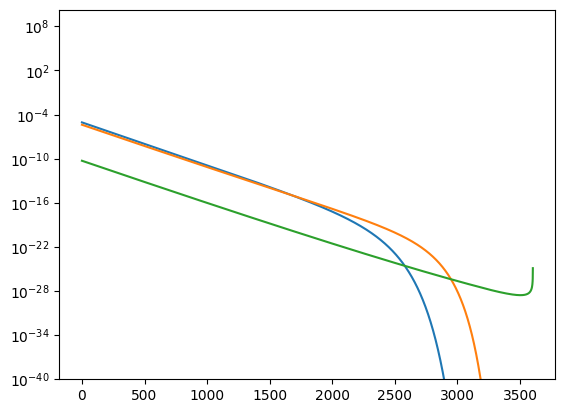

In [13]:
EPSILON = 1e-6

plt.plot(dNdM_Conditional(RtoM(200), 1.5, 20))
plt.plot(dNdM_Conditional(RtoM(200), 1.6, 20))
plt.plot(dNdM_Conditional(RtoM(200), 1.68-EPSILON, 20))
plt.yscale('log')
plt.ylim(1e-40, None)

In [14]:
z = 15.
delta_range = 1.68 - np.geomspace(1e-4, 1, 100)
r = 5.
cond_sfrd_arr = []

for j, delta in enumerate(delta_range):
    dndm_cond = np.nan_to_num(dNdM_Conditional(RtoM(r), delta, z))
    integrand = dndm_cond*f_duty(interp_m) * m_star_dot(interp_m, z)
    cond_sfrd_arr.append(np.trapz(integrand, interp_m))

/tmp/ipykernel_2240042/1392383503.py:46: RuntimeWarning: invalid value encountered in sqrt
  n12 = (delta1 - delta2) / np.sqrt(S1 - S2)
/tmp/ipykernel_2240042/1392383503.py:47: RuntimeWarning: invalid value encountered in sqrt
  differential = -interp_m * (delta1-delta2) / 2 / n12 / np.sqrt(S1-S2)**3*dS1_dM1


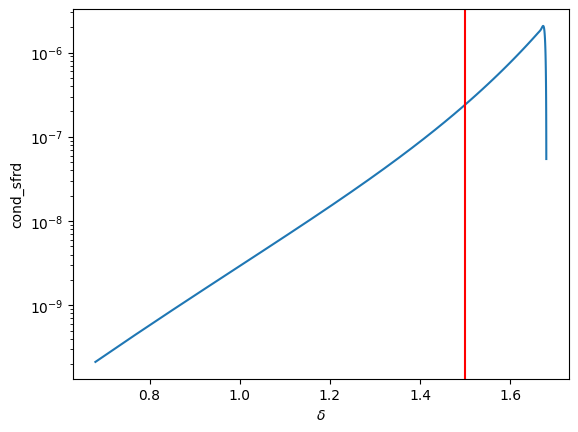

In [15]:
plt.plot(delta_range, cond_sfrd_arr)
plt.yscale('log')
plt.xlabel(r'$\delta$')
plt.ylabel(r'cond_sfrd')
plt.axvline(1.5, color='r')

In [17]:
z_range = np.linspace(0, 50, 128)
# delta_range = np.linspace(-1, 1.5, 128)
delta_range = 1.68 - np.geomspace(1e-4, 2.68, 129)
r_range = np.linspace(.1, 512, 130)

cond_sfrd = np.zeros((len(z_range), len(delta_range), len(r_range)))
for i, z in enumerate(tqdm(z_range)):
    for j, delta in enumerate(delta_range):
        for k, r in enumerate(r_range):
            dndm_cond = np.nan_to_num(dNdM_Conditional(RtoM(r), delta, z))
            integrand = dndm_cond*f_duty(interp_m) * m_star_dot(interp_m, z)
            cond_sfrd[i, j, k] = np.trapz(integrand, interp_m)

  0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_2240042/1392383503.py:46: RuntimeWarning: invalid value encountered in sqrt
  n12 = (delta1 - delta2) / np.sqrt(S1 - S2)
/tmp/ipykernel_2240042/1392383503.py:47: RuntimeWarning: invalid value encountered in sqrt
  differential = -interp_m * (delta1-delta2) / 2 / n12 / np.sqrt(S1-S2)**3*dS1_dM1
/tmp/ipykernel_2240042/1392383503.py:46: RuntimeWarning: divide by zero encountered in divide
  n12 = (delta1 - delta2) / np.sqrt(S1 - S2)
/tmp/ipykernel_2240042/1392383503.py:47: RuntimeWarning: invalid value encountered in divide
  differential = -interp_m * (delta1-delta2) / 2 / n12 / np.sqrt(S1-S2)**3*dS1_dM1
/tmp/ipykernel_2240042/1392383503.py:50: RuntimeWarning: invalid value encountered in multiply
  fPS = np.sqrt(2/np.pi)*n12*np.exp(-n12**2 / 2)
100%|██████████| 128/128 [24:10<00:00, 11.33s/it]


In [19]:
st_sfrd = np.zeros_like(z_range)

for i in range(len(z_range)):
    dndm_st = dNdM_st(interp_m, z_range[i])
    integrand = dndm_st*f_duty(interp_m) * m_star_dot(interp_m, z_range[i])
    st_sfrd[i] = np.trapz(integrand, interp_m)

In [26]:
sys.path.append("..")
from dm21cm.utils import save_h5_dict, load_h5_dict

In [51]:
table_dict = {
    'z_range' : z_range,
    'delta_range' : delta_range,
    'r_range' : r_range,
    'cond_sfrd_table' : cond_sfrd,
    'st_sfrd_table' : st_sfrd,
}
save_h5_dict("../data/sfrd/sfrd_tables.h5", table_dict)

In [52]:
# partially old table
table_prev = load_h5_dict(os.environ['DM21CM_DATA_DIR'] + "/tf/zf01/data/hmf_tables.h5")
table_dict = {
    'z_range' : z_range,
    'delta_range' : delta_range,
    'r_range' : r_range,
    'cond_sfrd_table' : cond_sfrd,
    'st_sfrd_table' : interpolate.interp1d(table_prev['z_range'], table_prev['st_sfrd_table'])(z_range),
}
save_h5_dict("../data/sfrd/sfrd_tables_partold.h5", table_dict)

In [56]:
# deploy
! cp ../data/sfrd/sfrd_tables.h5 $DM21CM_DATA_DIR/tf/zf01/data/sfrd_tables.h5

In [ ]:
# npy
res_dict = dict()
res_dict['SFRD_Params'] =np.array([z_range, delta_range, r_range], dtype = list)
res_dict['Cond_SFRD_Table'] = cond_sfrd
res_dict['ST_SFRD_Table'] = st_sfrd
np.savez('./Interpolators.npz', **res_dict, allow_pickle = True)

## previous tables

In [48]:
os.environ['DM21CM_DATA_DIR']

'/n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data'

In [49]:
! cp /n/holyscratch01/iaifi_lab/yitians/dm21cm/DM21cm/data/tf/zf01/data/hmf_tables.h5 hmf_tables_old.h5

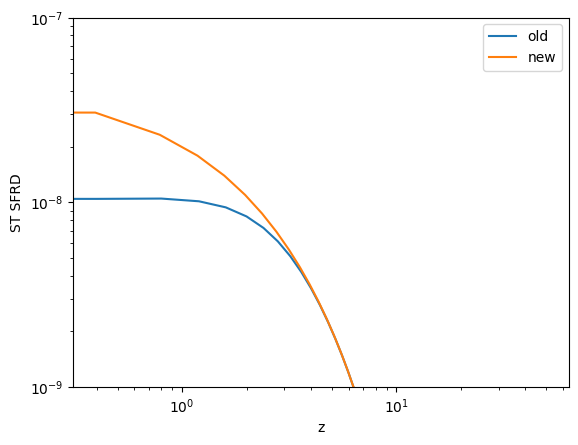

In [38]:
plt.plot(table_prev['z_range'], table_prev['st_sfrd_table'], label='old')
plt.plot(z_range, st_sfrd, label='new')
plt.loglog()
plt.ylim(1e-9, 1e-7)
plt.xlabel('z')
plt.ylabel('ST SFRD')
plt.legend()

In [41]:
z = 15.
r = 5.
ps_sfrd_interp = interpolate.RegularGridInterpolator((z_range, delta_range, r_range), cond_sfrd, bounds_error=False, fill_value=0)
ps_sfrd_arr = ps_sfrd_interp([[z, d, r] for d in delta_range])

old_ps_sfrd_interp = interpolate.RegularGridInterpolator((table_prev['z_range'], table_prev['delta_range'], table_prev['r_range']), table_prev['cond_sfrd_table'], bounds_error=False, fill_value=0)
old_ps_sfrd_arr = old_ps_sfrd_interp([[z, d, r] for d in delta_range])

Text(0, 0.5, 'cond_sfrd')

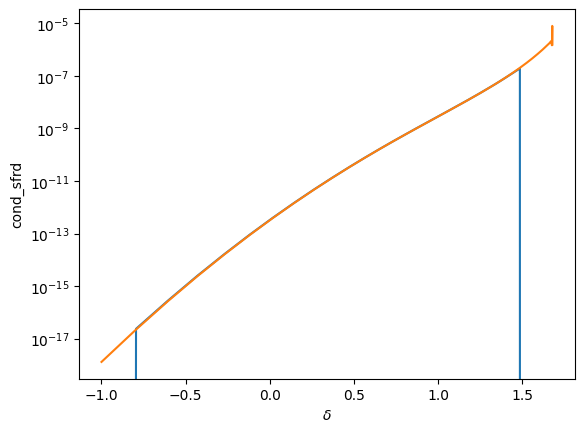

In [42]:
plt.plot(delta_range, old_ps_sfrd_arr, label='old')
plt.plot(delta_range, ps_sfrd_arr, label='new')
plt.yscale('log')
plt.xlabel(r'$\delta$')
plt.ylabel(r'cond_sfrd')